# Zeeman slower
This document provides all the information about how to design a Zeeman slower using a magnetic field.
Includes an optional interactive matplotlib widget that lets you vary key parameters with sliders.

## Brief theory introduction

The Zeeman slower is a device used to slow down a beam of atoms using the radiation pressure from a counter-propagating monochromatic laser beam, while compensating for the changing Doppler shift.
Therefore, the laser exerts a force on the atoms, slowing them down over a certain distance with a force, $F_{scatt} = \sigma_{abs} I/c = \hbar k R_{scatt}$, where $\sigma_{abs}$ is the absorption cross-section, $I$ is the laser intensity, $c$ is the speed of light, $\hbar$ is the reduced Planck constant, $k$ is the wavevector of the laser light, and $R_{scatt}$ is the scattering rate $$R_{scatt} = \frac{\Gamma}{2} \frac{\Omega^2/2}{\delta^2+\Omega^2/2+\Gamma^2/4}$$ where $\Gamma$ is the linewidth, $\Omega$ is the Rabi frequency, and $\delta (z) = \omega - \omega_0 +kv(z)$ is the detuning where $\omega$ is the laser frequency, $\omega_0$ is the atomic transition frequency, and $kv(z)$ is the Doppler shift.
We can also define the laser detuning at rest as $\delta_0 = \omega - \omega_0$ such that the detuning becomes $\delta (z) = \delta_0 +kv(z)$.

Defining the saturation parameter as $s = I/I_{sat} = 2 \Omega^2/\Gamma^2$, where $I_{sat}$ is the saturation intensity, we can rewrite the scattering force as:$$F_{scatt} = \hbar k \frac{\Gamma}{2} \frac{s}{1+s+4(\delta/\Gamma)^2}.$$

When the intensity tends to infinity ($s \gg 1$) and the detuning is zero ($\delta = 0$), the scattering rate reaches its maximum value of $R_{scatt,max} = \Gamma/2$, leading to a maximum deceleration of the atoms given by:
$$a_{max} = \frac{F_{scatt,max}}{m} = \frac{\hbar k}{m} \frac{\Gamma}{2} = \frac{v_r}{2\tau}$$
where $m$ is the mass of the atom, $v_r = \hbar k / m$ is the recoil velocity, and $\tau$ is the excited state lifetime.

### Species properties and constants
Here we define relevant properties (mass, wavelength and linewidth) of several common atomic species used for laser cooling.
Such that we can use their linewidth to study in first instance the range where the scattering rate is significant for different saturation parameters.
We also define some useful constants and import necessary libraries.

In [ ]:
%matplotlib inline

# Imports and setup
import math
import wave
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as w
from IPython.display import display, clear_output

# Physical constants (SI units)
hh = 6.62607015e-34  # J*s (Planck constant)
hbar = hh / (2.0 * math.pi)
mu = 9.274009994e-24  # J/T (Bohr magneton)
amu = 1.66053906660e-27  # kg (atomic mass unit)

# Species dropdown with mass, wavelength (m), and gamma (rad/s)
species_data = {
    'Ca-40':   {'mass': 40.078,  'wavelength': 422.67276e-9, 'gamma': 2 * math.pi * 34.6e6},
    'Sr-88':   {'mass': 87.62,   'wavelength': 460.862e-9,    'gamma': 2 * math.pi * 32.0e6},
    'Rb-87':   {'mass': 86.909,  'wavelength': 780.241e-9,    'gamma': 2 * math.pi * 6.065e6},
    'Cs-133':  {'mass': 132.905, 'wavelength': 852.347e-9,    'gamma': 2 * math.pi * 5.234e6},
    'Na-23':   {'mass': 22.990,  'wavelength': 589.158e-9,    'gamma': 2 * math.pi * 9.79e6},
    'Yb-174':  {'mass': 173.045, 'wavelength': 398.911e-9,    'gamma': 2 * math.pi * 29.0e6},
}

species = w.Dropdown(
    description='Species',
    options=list(species_data.keys()),
    value='Ca-40'
 )

# If the interactive widgets already exist, refresh them so display labels
# pick up any newly edited parameter values (e.g., gamma).
for refresh_func_name in ("refresh_simple", "refresh_advanced"):
    refresh_callable = globals().get(refresh_func_name)
    if callable(refresh_callable):
        try:
            refresh_callable()
        except Exception as exc:
            print(f"Warning: {refresh_func_name} failed to refresh ({exc})")

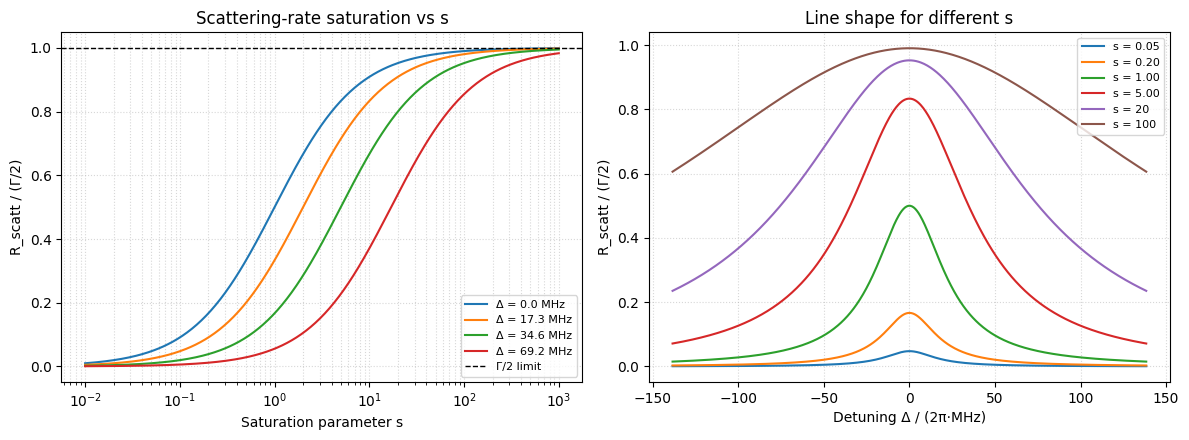

In [2]:
# Visualize how the scattering rate depends on saturation parameter and detuning
def scattering_rate(s, delta, gamma):
    return 0.5 * gamma * (s / (1.0 + s + 4.0 * (delta / gamma) ** 2))

current_species = species_data[species.value]
gamma_val = current_species["gamma"]

s_values = np.logspace(-2, 3, 400)
detuning_values = np.linspace(-4 * gamma_val, 4 * gamma_val, 600)

detuning_samples = [0.0, 0.5 * gamma_val, 1.0 * gamma_val, 2.0 * gamma_val]
saturation_samples = [0.05, 0.2, 1.0, 5.0, 20.0, 100.0]

rates_vs_s = {delta: scattering_rate(s_values, delta, gamma_val) for delta in detuning_samples}
rates_vs_delta = {s: scattering_rate(s, detuning_values, gamma_val) for s in saturation_samples}

fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(12, 4.5))

for delta, rates in rates_vs_s.items():
    label = f"Δ = {delta / (2 * math.pi * 1e6):.1f} MHz"
    ax_left.plot(s_values, rates / (gamma_val / 2), label=label)
ax_left.axhline(1.0, color="k", ls="--", lw=1, label="Γ/2 limit")
ax_left.set_xscale("log")
ax_left.set_xlabel("Saturation parameter s")
ax_left.set_ylabel("R_scatt / (Γ/2)")
ax_left.set_title("Scattering-rate saturation vs s")
ax_left.legend(loc="lower right", fontsize=8)
ax_left.grid(True, which="both", ls=":", alpha=0.5)

for s_val, rates in rates_vs_delta.items():
    label = f"s = {s_val:.2f}" if s_val < 10 else f"s = {s_val:.0f}"
    ax_right.plot(detuning_values / (2 * math.pi * 1e6), rates / (gamma_val / 2), label=label)
ax_right.set_xlabel("Detuning Δ / (2π·MHz)")
ax_right.set_ylabel("R_scatt / (Γ/2)")
ax_right.set_title("Line shape for different s")
ax_right.legend(loc="upper right", fontsize=8)
ax_right.grid(True, ls=":", alpha=0.5)

plt.tight_layout()
plt.show()

Here, we assume we are slowing down atoms at a constant deceleration using a counter-propagating laser beam at a rate $\frac{dv}{dt} = v \frac{dv}{dz} = - a$, and when we integrate over position we get the velocity profile as a function of position. Assuming constant deceleration, we can express the velocity as a function of position z along the slower as:
$$v(z) = \sqrt{v_0^2 - 2 a z}$$
where $v_0 = v(z=0)$ is the initial velocity of the atoms at the entrance of the slower, and $a$ is the constant deceleration which is usually expressed $a=\eta a_{max}$ where $\eta \in [0,1]$ is typically between 0.5 and 0.8 to give some margin compared to the maximum deceleration.
Thus, the stopping distance L required to slow atoms from initial velocity $v_0$ to final velocity $v_f = v(z=L)$ is given by:
$$L = \frac{v_0^2 - v_f^2}{2 \eta a_{max}}$$
such that we can express the velocity profile:
$$v(z) = \sqrt{v_0^2 - \left(v_0^2 - v_f^2\right)\frac{z}{L}}$$

Assuming $v_f=0$, $L = \frac{v_0^2}{2 \eta a_{max}}$ and $v(z) = v_0 \sqrt{1 - \frac{z}{L}}$.

When a beam of particles is slowed down using a counter-propagating laser beam, the particles experience a changing Doppler shift, $k v(z)$, as they decelerate.
To maintain resonance between the laser frequency and the atomic transition, a spatially varying magnetic field, $B(z)$, is applied along the length of the slower (or a chirped laser $\omega_L (z)$).

This magnetic field induces a Zeeman shift in the atomic energy levels, compensating for the changing Doppler shift.
$$\omega_0 \pm \frac{\mu B(z)}{\hbar} = \omega_L + k v(z)$$
where $\omega_0$ is the atomic transition frequency, $\omega_L$ is the laser frequency, $\mu$ is the Bohr magneton, and $v(z)$ is the velocity of the atoms at position z.

Hence, the ideal magnetic field profile for a Zeeman slower that maintains resonance throughout the slowing process until $v_f = 0$ via decreasing the field (+sign and $\sigma^+$ polarization) is given by:
$$B_+(z) = B_{bias,+} + B_0\sqrt{1-\frac{z}{L}}$$
where $B_0 = \frac{\hbar k v_0}{\mu} = \frac{h v_0}{\lambda \mu}$ is the maximum magnetic field strength at the entrance of the slower, and $B_{bias,+}$ is a constant offset magnetic field, such that $\mu B_{bias,+} = \hbar \delta_0$ where $\delta_0 = \omega_L - \omega_0$ is the detuning of the laser frequency from the atomic transition frequency.

Whereas the decreasing-field Zeeman slower (-sign and $\sigma^-$ polarization) is for a general final velocity $v_f$,
$$B_-(z) = B_{bias,-} + B_0\left(1-\sqrt{1-\frac{v_0^2 - v_f^2}{v_0^2}\frac{z}{L}}\right)$$
where $B_{bias,-}$ is a constant offset magnetic field, such that $\mu (B_{bias,-} + B_0)= - \hbar \delta_0$ where $\delta_0 = \omega_L - \omega_0$ is the detuning of the laser frequency from the atomic transition frequency.

In case of need to look for more spectral lines, please refer to: https://physics.nist.gov/PhysRefData/ASD/lines_form.html

Or atoms information Safranova 
https://www1.udel.edu/atom

## The following code aims to study the decreasing-field Zeeman slower for a general final velocity vf

### Simple model for Zeeman slower design

Assuming final velocity 0 and increasing-field Zeeman slower.

In [ ]:
def plot_profile(z_plt, v_plt, B_plt, L_plt):
    """Plot magnetic field (Gauss) and velocity using discrete markers."""
    fig, ax1 = plt.subplots(figsize=(7, 4))
    ax1.set_xlabel("z (m)")
    ax1.set_ylabel("B (G)", color="tab:blue")
    ax1.scatter(z_plt, B_plt * 1e4, color="tab:blue", s=15, label="B(z) [G]")
    ax1.tick_params(axis="y", labelcolor="tab:blue")
    ax1.grid(True, ls="--", alpha=0.4)
    ax2 = ax1.twinx()
    ax2.set_ylabel("v (m/s)", color="tab:orange")
    ax2.scatter(z_plt, v_plt, color="tab:orange", s=15, label="v(z) [m/s]")
    ax2.tick_params(axis="y", labelcolor="tab:orange")
    max_B = np.nanmax(B_plt * 1e4) if np.size(B_plt) else 1.0
    max_v = np.nanmax(v_plt) if np.size(v_plt) else 1.0
    max_B = max(1e-8, max_B) * 1.05
    max_v = max(1e-8, max_v) * 1.05
    ax1.set_ylim(0.0, max_B)
    ax2.set_ylim(0.0, max_v)
    ax1.set_title(f"Zeeman slower profile (L = {L_plt:.3f} m)")
    plt.tight_layout()
    plt.show()


def compute_B_z_simple(
    L_z=0.3,
    wavelength=422.67276e-9,
    v0=500.0,
    n_points=500,
    B_bias=200.0e-4,
 ):
    zz = np.linspace(0.0, L_z, n_points)
    vv = v0 * np.sqrt(1 - zz / L_z)
    B_z = B_bias + (hh * v0) / (mu * wavelength) * (np.sqrt(1 - zz / L_z))
    return zz, vv, B_z, L_z

# Sliders for the simple model
v0_simple = w.FloatSlider(description="v0 (m/s)", value=500.0, min=0.0, max=1200.0, step=5.0, continuous_update=False)
L_z_simple = w.FloatSlider(description="L_z (m)", value=0.3, min=0.05, max=1.0, step=0.01, continuous_update=False)
points_simple = w.IntSlider(description="points", value=600, min=200, max=2000, step=50, continuous_update=False)
B_bias_simple = w.FloatSlider(description="B_bias (G)", value=200.0, min=0.0, max=1000.0, step=1.0, continuous_update=False)

wavelength_label_simple = w.HTML()
gamma_label_simple = w.HTML()
out_simple = w.Output()


def update_info_simple():
    d = species_data[species.value]
    wavelength_label_simple.value = f"<b>λ</b>: {d['wavelength']*1e9:.3f} nm"
    gamma_label_simple.value = f"<b>Γ/2π</b>: {d['gamma']/(2*math.pi)/1e6:.3f} MHz"


def refresh_simple(change=None):
    with out_simple:
        clear_output(wait=True)
        d = species_data[species.value]
        update_info_simple()
        try:
            zz, vv, BB, LL = compute_B_z_simple(
                L_z=L_z_simple.value,
                wavelength=d['wavelength'],
                v0=v0_simple.value,
                n_points=points_simple.value,
                B_bias=B_bias_simple.value * 1e-4,
            )
        except Exception as exc:
            print("Parameter error:", exc)
            return
        plot_profile(zz, vv, BB, LL)


for widget in (species, v0_simple, L_z_simple, points_simple, B_bias_simple):
    widget.observe(refresh_simple, names='value')

ui_simple = w.VBox([
    w.HBox([species, wavelength_label_simple, gamma_label_simple]),
    w.HBox([v0_simple, L_z_simple, points_simple]),
    w.HBox([B_bias_simple]),
])

refresh_simple()
display(ui_simple, out_simple)

Output()

In [ ]:
def compute_B_z_forces(mass_amu=40.078, wavelength=422.67276e-9, gamma=2*math.pi*34.6e6, g_eff=1.0,
                    v0=500.0, vf=50.0, B_bias=250, eta=0.5, n_points=500):
    m = mass_amu * amu
    k = 2 * math.pi / wavelength
    F_max = hbar * k * gamma / 2.0
    print(f"max force: {F_max:.3e} N")
    a_max = F_max / m
    a = eta * a_max
    if a <= 0:
        raise ValueError("Computed deceleration <= 0; check s0 and eta")
    if v0 <= vf:
        raise ValueError("Initial velocity v0 must be > final velocity vf")
    L = (v0 * v0 - vf * vf) / (2.0 * a)
    print(f"length: {L*100:.3f} cm")
    B_delta = hbar * k / (mu * g_eff) * v0
    print(f"B_delta: {B_delta:.3e} T")
    B_bias_T = B_bias * 1e-4
    z = np.linspace(0.0, L, n_points)
    v = np.sqrt(v0**2 - (v0**2 - vf**2) * z / L)
    BB = B_bias_T + B_delta * (1 - np.sqrt(1 - ((v0**2 - vf**2) / v0**2) * (z / L)))
    detu = - mu * g_eff * (B_bias_T + B_delta) / hbar
    print('Detuning:', detu, 'Hz')
    return z, v, BB, L, detu

v0_adv = w.FloatSlider(description="v0 (m/s)", value=500.0, min=0.0, max=1200.0, step=5.0, continuous_update=False)
vf_adv = w.FloatSlider(description="vf (m/s)", value=50.0, min=0.0, max=600.0, step=5.0, continuous_update=False)
eta_adv = w.FloatSlider(description="eta", value=0.5, min=0.01, max=1.0, step=0.01, continuous_update=False)
B_bias_adv = w.FloatSlider(description="B_bias (Gauss)", value=250.0, min=1.0, max=500.0, step=1.0, continuous_update=False)
g_eff_adv = w.FloatSlider(description="g_eff", value=1.0, min=0.1, max=2.0, step=0.01, continuous_update=False)
points_adv = w.IntSlider(description="points", value=600, min=200, max=2000, step=50, continuous_update=False)

wavelength_label_advanced = w.HTML()
gamma_label_advanced = w.HTML()
out_advanced = w.Output()


def update_info_advanced():
    d = species_data[species.value]
    wavelength_label_advanced.value = f"<b>λ</b>: {d['wavelength']*1e9:.3f} nm"
    gamma_label_advanced.value = f"<b>Γ/2π</b>: {d['gamma']/(2*math.pi)/1e6:.3f} MHz"


def refresh_advanced(change=None):
    with out_advanced:
        clear_output(wait=True)
        d = species_data[species.value]
        update_info_advanced()
        try:
            z, v, B, L, detu = compute_B_z_forces(
                mass_amu=d['mass'],
                wavelength=d['wavelength'],
                gamma=d['gamma'],
                v0=v0_adv.value,
                vf=vf_adv.value,
                eta=eta_adv.value,
                B_bias=B_bias_adv.value,
                g_eff=g_eff_adv.value,
                n_points=points_adv.value,
            )
        except Exception as exc:
            print("Parameter error:", exc)
            return
        plot_profile(z, v, B, L)


for widget in (species, v0_adv, vf_adv, eta_adv, B_bias_adv, g_eff_adv, points_adv):
    widget.observe(refresh_advanced, names='value')

ui_advanced = w.VBox([
    w.HBox([species, wavelength_label_advanced, gamma_label_advanced]),
    w.HBox([v0_adv, vf_adv, eta_adv]),
    w.HBox([B_bias_adv, g_eff_adv, points_adv]),
])

refresh_advanced()
display(ui_advanced, out_advanced)

Output()

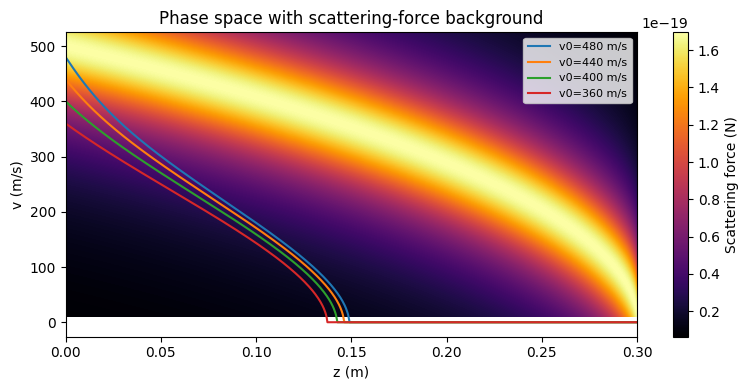

In [ ]:
# Phase-space trajectories for the ideal Zeeman field profile
import numpy as np
import matplotlib.pyplot as plt

species_name = "Ca-40"
spec = species_data[species_name]
wavelength = spec["wavelength"]
gamma = spec["gamma"]
mass = spec["mass"] * amu
k = 2 * math.pi / wavelength
g_eff_val = 1.0

v_capture = 500.0  # m/s
v_final = 50.0  # m/s
s0_val = 200.0
B_bias_gauss = 200.0
L_design = 0.30

z_axis, v_profile, B_profile_T, _ = compute_B_z_simple(
    L_z=L_design,
    wavelength=wavelength,
    v0=v_capture,
    n_points=800,
    B_bias=B_bias_gauss * 1e-4,
)

# Laser detuning chosen so the entrance stays on resonance
# delta = delta_laser + k*v - g*mu*B/hbar = 0 when z=0 and v=v_capture
# => delta_laser = g*mu*B(0)/hbar - k*v_capture
delta_laser = g_eff_val * mu * B_profile_T[0] / hbar - k * v_capture


def scattering_force(B_T, velocity):
    delta = delta_laser + k * velocity - g_eff_val * mu * B_T / hbar
    denom = 1.0 + s0_val + (2.0 * delta / gamma) ** 2
    return hbar * k * gamma / 2.0 * (s0_val / denom)


def integrate_trajectory(v_init):
    traj = np.zeros_like(z_axis)
    traj[0] = v_init
    for idx in range(len(z_axis) - 1):
        v_curr = max(traj[idx], 1e-6)
        dz = z_axis[idx + 1] - z_axis[idx]
        force = scattering_force(B_profile_T[idx], v_curr)
        acc = force / mass
        traj[idx + 1] = max(traj[idx] - acc * dz / v_curr, 0.0)
    return traj


vel_axis = np.linspace(v_final * 0.2, v_capture * 1.05, 400)
force_grid = np.zeros((len(z_axis), len(vel_axis)))
for i, B_val in enumerate(B_profile_T):
    delta = delta_laser + k * vel_axis - g_eff_val * mu * B_val / hbar
    denom = 1.0 + s0_val + (2.0 * delta / gamma) ** 2
    force_grid[i] = hbar * k * gamma / 2.0 * (s0_val / denom)

initial_velocities = [480.0, 440.0, 400.0, 360.0]

fig, ax = plt.subplots(figsize=(8, 4))
im = ax.imshow(
    force_grid.T,
    extent=[z_axis[0], z_axis[-1], vel_axis[0], vel_axis[-1]],
    origin="lower",
    aspect="auto",
    cmap="inferno",
)
for v_init in initial_velocities:
    traj = integrate_trajectory(v_init)
    ax.plot(z_axis, traj, label=f"v0={v_init:.0f} m/s")

ax.set_xlabel("z (m)")
ax.set_ylabel("v (m/s)")
ax.set_title("Phase space with scattering-force background")

cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Scattering force (N)")
ax.legend(loc="upper right", fontsize=8)
plt.tight_layout()
plt.show()